In [1]:
# Run on python 3.6
import time
import numpy as np

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
%matplotlib inline

# Building the model

In [2]:
h = [784,512,256,10]
# Don't forget the bias in the count
nb_params = [(h[i]+1)*h[i+1] for i in range(len(h)-1)]
total_params = sum(nb_params)
print("Number of parameters per layer:{} and total: {}".format(nb_params,total_params))

Number of parameters per layer:[401920, 131328, 2570] and total: 535818


In [3]:
class MultiLayerPerceptron(nn.Module):
    
    def __init__(self,sizes):
        super(MultiLayerPerceptron, self).__init__()
        self.sizes = sizes
        
        layers = []
        for i in range(len(sizes)-2):
            layers.append(nn.Linear(sizes[i],sizes[i+1],bias=True))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(sizes[-2],sizes[-1],bias=True))
        
        self.predict_ = nn.Sequential(*layers)
        
        self.criterion = nn.CrossEntropyLoss()
        
    def forward(self,x):
        x = x.view(-1,784)
        return self.predict_(x)
    
    def predict_proba(self, x):
        return nn.Softmax(dim=1)(x)
    
    def predict(self, x):
        return torch.max(self.predict_proba(x),1)[1]
    
    def loss(self, x, target):
        proba = self(x)
        return self.criterion(proba, target)
    

In [4]:
mlp = MultiLayerPerceptron(h)

In [5]:
mlp.predict_

Sequential(
  (0): Linear(in_features=784, out_features=512)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=256)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=10)
)

## Optimization Parameters

In [6]:
class Args:
    def __init__(self):
        self.cuda = torch.cuda.is_available()
        self.batch_size = 32
        self.test_batch_size = 5
        self.learning_rate = .01
        self.momentum=0
        self.log_interval = 500
        self.epochs=10
    
args = Args()
kwargs  = {}
if args.cuda:
    mlp.cuda()

In [7]:
args.cuda

True

In [8]:
optimizer = optim.SGD(mlp.parameters(), lr=args.learning_rate, momentum=args.momentum)

## Dataset

In [9]:
def data_loaders(args):
    from torch.utils.data.sampler import SubsetRandomSampler

    download_loc = "/Tmp/lepriolr/"
    mnist_train = datasets.MNIST(download_loc, train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,)),
                       ]))

    mnist_test = datasets.MNIST(download_loc, train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ]))
    nb_train = 50000
    train_loader = torch.utils.data.DataLoader(
            mnist_train, 
            sampler=SubsetRandomSampler(np.arange(nb_train)),
            batch_size=args.batch_size, **kwargs)

    valid_loader = torch.utils.data.DataLoader(
            mnist_train, 
            sampler=SubsetRandomSampler(np.arange(nb_train,len(mnist_train))),
            batch_size=args.batch_size, **kwargs)

    test_loader = torch.utils.data.DataLoader(mnist_test,
        batch_size=args.test_batch_size, shuffle=True, **kwargs)
    
    return train_loader, valid_loader, test_loader

train_loader,valid_loader,test_loader = data_loaders(args)

Processing...
Done!


## Optimization loop

In [10]:
def train(mlp, optimizer, epoch_idx,printing=True):
    ans= []
    
    for batch_idx, (data, target) in enumerate(train_loader):
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        loss = mlp.loss(data, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            if printing:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch_idx, batch_idx * train_loader.batch_size, len(train_loader.sampler),
                    100. * batch_idx / len(train_loader), loss.data[0]))
            ans.append((batch_idx * train_loader.batch_size+ epoch_idx*len(train_loader.sampler), loss.data[0]))

    return ans


In [11]:
train(mlp, optimizer, 0)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.318316
Train Epoch: 0 [16000/50000 (32%)]	Loss: 0.398803
Train Epoch: 0 [32000/50000 (64%)]	Loss: 0.366071
Train Epoch: 0 [48000/50000 (96%)]	Loss: 0.443953


[(0, 2.3183164596557617),
 (16000, 0.39880305528640747),
 (32000, 0.3660711646080017),
 (48000, 0.4439525008201599)]

In [ ]:
def validation(mlp, loader):
    valid_loss = 0
    correct = 0
    for data, target in loader:
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = mlp(data)
        valid_loss += F.cross_entropy(output, target, size_average=False).data[0] # sum up batch loss
        pred = mlp.predict(output)
        correct += pred.data.eq(target.data.view_as(pred)).cpu().sum()

    valid_loss /= len(loader.dataset)
    accuracy = correct / len(loader.sampler)
    print('Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        valid_loss, correct, len(loader.sampler),
        100. * accuracy))
    
    return valid_loss,accuracy


In [13]:
validation(mlp, train_loader)


 Validation set: Average loss: 0.2384, Accuracy: 45820/50000 (92%)



(0.2384420830051104, 0.9164)

# Initialization

In [14]:
# Below m stands for module
# this functon is applied recursively to all the sub-modules of a neural network
def init_zero(m):
    if type(m) == nn.Linear:
        nn.init.constant(m.weight,0)
        nn.init.constant(m.bias,0)

        
def init_normal(m):
    if type(m) == nn.Linear:
        nn.init.normal(m.weight,mean=0,std=1)
        nn.init.constant(m.bias,0)
        
        
def init_glorot(m):
    gain = nn.init.calculate_gain('relu')
    if type(m) == nn.Linear:
        nn.init.xavier_uniform(m.weight,gain=gain)
        nn.init.constant(m.bias,0)


In [15]:
mlp.apply(init_glorot)
pass

In [219]:
train_loss = []
for epoch in range(1, args.epochs + 1):
    train(mlp, optimizer, epoch, printing=True)
    train_loss.append(mlp, validation(train_loader)[0])
print(train_loss)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.302585
Train Epoch: 1 [16000/50000 (32%)]	Loss: 2.299696
Train Epoch: 1 [32000/50000 (64%)]	Loss: 2.295147
Train Epoch: 1 [48000/50000 (96%)]	Loss: 2.297716

 Validation set: Average loss: 1.9176, Accuracy: 5678/50000 (11%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 2.301996
Train Epoch: 2 [16000/50000 (32%)]	Loss: 2.314201
Train Epoch: 2 [32000/50000 (64%)]	Loss: 2.309832
Train Epoch: 2 [48000/50000 (96%)]	Loss: 2.307774

 Validation set: Average loss: 1.9175, Accuracy: 5678/50000 (11%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 2.312147
Train Epoch: 3 [16000/50000 (32%)]	Loss: 2.301348
Train Epoch: 3 [32000/50000 (64%)]	Loss: 2.296131
Train Epoch: 3 [48000/50000 (96%)]	Loss: 2.288685

 Validation set: Average loss: 1.9175, Accuracy: 5678/50000 (11%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 2.315754
Train Epoch: 4 [16000/50000 (32%)]	Loss: 2.293621
Train Epoch: 4 [32000/50000 (64%)]	Loss: 2.316525
Train Epoch: 4 [48000/50000 (96%)]	Loss: 2.308353

 Validation set

In [220]:
print(', '.join('{:.2e}'.format(k) for k in train_loss))

1.92e+00, 1.92e+00, 1.92e+00, 1.92e+00, 1.92e+00, 1.92e+00, 1.92e+00, 1.92e+00, 1.92e+00, 1.92e+00


In [221]:
#zero_loss = train_loss
#normal_loss = train_loss
#glorot_loss = train_loss

In [225]:
np.save("results/compare_init.npy",[zero_loss,normal_loss,glorot_loss])

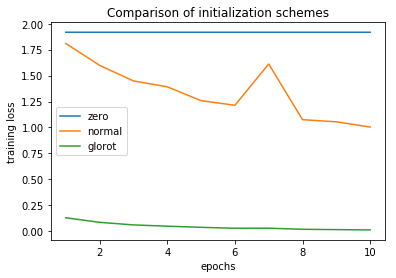

In [224]:
xaxis = np.arange(1,11)
plt.plot(xaxis, zero_loss,label='zero')
plt.plot(xaxis, normal_loss, label='normal')
plt.plot(xaxis, glorot_loss, label='glorot')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("training loss")
plt.title("Comparison of initialization schemes")
plt.savefig("results/compare_init.pdf")

## Learning curves

In [25]:
mlp.apply(init_glorot)
results = []
results.append(validation(mlp, train_loader))
results.append(validation(mlp, valid_loader))


 Validation set: Average loss: 4.2775, Accuracy: 4214/50000 (8%)


 Validation set: Average loss: 0.8445, Accuracy: 806/10000 (8%)



In [ ]:
args.epochs = 100
for epoch in range(args.epochs):
    print("Epoch ", epoch)
    train(mlp, optimizer, epoch, printing=False)
    results1.append(validation(mlp, train_loader))
    results1.append(validation(mlp, valid_loader))

Epoch  0

 Validation set: Average loss: 0.1292, Accuracy: 47689/50000 (95%)


 Validation set: Average loss: 0.0283, Accuracy: 9514/10000 (95%)

Epoch  1

 Validation set: Average loss: 0.0804, Accuracy: 48666/50000 (97%)


 Validation set: Average loss: 0.0220, Accuracy: 9634/10000 (96%)

Epoch  2

 Validation set: Average loss: 0.0623, Accuracy: 49010/50000 (98%)


 Validation set: Average loss: 0.0196, Accuracy: 9666/10000 (97%)

Epoch  3

 Validation set: Average loss: 0.0459, Accuracy: 49322/50000 (99%)


 Validation set: Average loss: 0.0176, Accuracy: 9713/10000 (97%)

Epoch  4

 Validation set: Average loss: 0.0394, Accuracy: 49431/50000 (99%)


 Validation set: Average loss: 0.0169, Accuracy: 9699/10000 (97%)

Epoch  5

 Validation set: Average loss: 0.0306, Accuracy: 49625/50000 (99%)


 Validation set: Average loss: 0.0164, Accuracy: 9722/10000 (97%)

Epoch  6

 Validation set: Average loss: 0.0241, Accuracy: 49725/50000 (99%)


 Validation set: Average loss: 0.0155, Accura


 Validation set: Average loss: 0.0162, Accuracy: 9780/10000 (98%)

Epoch  56

 Validation set: Average loss: 0.0008, Accuracy: 50000/50000 (100%)


 Validation set: Average loss: 0.0162, Accuracy: 9785/10000 (98%)

Epoch  57

 Validation set: Average loss: 0.0008, Accuracy: 50000/50000 (100%)


 Validation set: Average loss: 0.0163, Accuracy: 9781/10000 (98%)

Epoch  58

 Validation set: Average loss: 0.0008, Accuracy: 50000/50000 (100%)


 Validation set: Average loss: 0.0163, Accuracy: 9788/10000 (98%)

Epoch  59

 Validation set: Average loss: 0.0008, Accuracy: 50000/50000 (100%)


 Validation set: Average loss: 0.0163, Accuracy: 9785/10000 (98%)

Epoch  60

 Validation set: Average loss: 0.0008, Accuracy: 50000/50000 (100%)


 Validation set: Average loss: 0.0163, Accuracy: 9783/10000 (98%)

Epoch  61

 Validation set: Average loss: 0.0007, Accuracy: 50000/50000 (100%)


 Validation set: Average loss: 0.0164, Accuracy: 9786/10000 (98%)

Epoch  62

 Validation set: Average loss: 0.

In [ ]:
train_accuracy = [j for i,j in  results[::2]]
valid_accuracy = [j for i,j in  results[1::2]]
print("training set :", train_accuracy)
print("validation set :", valid_accuracy)

In [ ]:
train_accuracy_low = train_accuracy
valid_accuracy_low = valid_accuracy 
#train_accuracy_high = train_accuracy
#valid_accuracy_high = valid_accuracy 

In [ ]:
h1 = [784,1024,256,10]
mlp1 = MultiLayerPerceptron(h)
optimizer1 = optim.SGD(mlp#.parameters(), lr=args.learning_rate, momentum=args.momentum)
mlp1.apply(init_glorot)
results1 = []
results1.append(validation(mlp1,train_loader))
results1.append(validation(mlp1, valid_loader))

In [ ]:
for epoch in range(args.epochs):
    print("Epoch ", epoch)
    train(mlp1, optimizer1, epoch, printing=False)
    results1.append(validation(mlp1, train_loader))
    results1.append(validation(mlp1, valid_loader))

In [ ]:
xaxis = np.arange(args.eporch) 
plt.plot(xaxis, train_accuracy_low, label="train low")
plt.plot(xaxis, valid_accuracy_low, label="valid low")
#plt.plot(xaxis, train_accuracy_high, label="train high")
#plt.plot(xaxis, train_accuracy_high, label="train high")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Generalization performance with high and low capacity models")
plt.savefig("results/compare_init.pdf")

## Training set size, generalization gap and standard error

In [ ]:
fractions = [.01,.02,.05,.1,1]